In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
from pathlib import Path
import brody as bd
from scipy.ndimage import gaussian_filter
import tqdm
import scipy.stats

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'

pygame 2.1.3.dev4 (SDL 2.0.20, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Recon Dataframe format

We have 478.71 +/- reconstructed events per SNe event, all in a single dataframe. We have 500 SnE
events altogether, written to files in the format `recon_<number>.h5`, where \<number\> is
the run number with 6 digits.

In [2]:
paths = sorted(Path("/nfs/disk1/youngsam/sims/2023-03-23_SNe").glob("recon_*.h5"))
print("Found {} files".format(len(paths)))
bd.File(paths[0], "r")

Found 500 files


/nfs/disk1/youngsam/sims/2023-03-23_SNe/recon_000000.h5/
├cosalpha	[float64: 483]
├eDir	[float64: 483 × 3]
├eKE	[float64: 483]
├flavor	[int64: 483]
├nuEnergy	[float64: 483]
├recon	[float64: 483 × 7]
├sn_direction	[float64: 3]
└truth	[float64: 483 × 7]

In [ ]:
def cart2sph(x, y, z):
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    return phi, theta - np.pi/2  # [-pi, pi], [-np.pi/2, pi/2]

def prepare_xyz(df):
    """Failed fits have -999 for x,y,z, so remove those"""
    df = np.atleast_2d(df[:].copy())
    x,y,z = df.T
    isnan = np.logical_or.reduce([x==-999, y==-999, z==-999])
    x,y,z = x[~isnan], y[~isnan], z[~isnan]
    phi, theta = cart2sph(x,y,z)
    return phi, theta

def contourf(ax, phi, theta, **kwargs):
    """Plot a contour of the 2D histogram of phi, theta."""
    sigma = kwargs.pop("sigma", 4)
    bins = kwargs.pop("bins", 100)

    # histogram
    H, X, Y = np.histogram2d(phi, theta, bins, range=[[-np.pi, np.pi], [-np.pi/2, np.pi/2]])
    # bin centers
    XE, YE = (X[1:] + X[:-1])/2, (Y[1:] + Y[:-1])/2
    # smooth so the contour isn't crazy
    H = gaussian_filter(H, sigma)
    ax.contourf(XE, YE, H.T, **kwargs)
    

def plot_df(filename, /, save=False):
    """Plot the reconstructed and true event directions."""
    run_number = re.search(r"recon_(\d+).h5", str(filename)).group(1)
    df = bd.File(filename, "r")
    
    fig = plt.figure(figsize=(10, 5), dpi=200)
    ax = fig.add_subplot(111, projection="mollweide")
    ax.grid(True, zorder=-999, alpha=0.2, color="grey", lw=0.5)
    ax.set_axisbelow(True)

    # convert from cartesian to spherical coordinates
    rphi, rtheta   = prepare_xyz(df['recon'][:, 4:7])
    tphi, ttheta   = prepare_xyz(df['sn_direction'])
    
    # -- reconstructed event directions
    energies = df['eKE'][:]
    energies = energies[df['cosalpha'][:] != -999]
    
    d = ax.scatter(rphi, rtheta, cmap='plasma', c=energies, alpha=1, label="Recon eEs Direction",
                   s=3, zorder=10000, norm=matplotlib.colors.LogNorm(vmax=100)
            )
    fig.colorbar(d, label="Electron Energy (MeV)", shrink=0.8, pad=0.05, aspect=20)
    #    contour
    contourf(ax, rphi, rtheta, bins=100, levels=5, cmap='GnBu', alpha=1, zorder=0)
    
    # true SNe direction
    ax.plot(tphi, ttheta, ls=None, marker='o', color='white', markersize=6,
            alpha=1, zorder=1e9, label='True SNe Direction', 
            fillstyle='full', linewidth=1,
            markerfacecolor="yellow", markeredgecolor="black", markeredgewidth=1)

    # true event directions
    # tsphi, tstheta = prepare_xyz(df['truth'][:, 4:7])
    # ax.plot(tsphi, tstheta, 'o', color='red', markersize=1, alpha=0.1, label='True eES Direction', zorder=-999)
    
    # plot nhit
    ax.text(0, 1.05, f"NEvents: {df['cosalpha'].len()}", ha='right', va='center', fontsize=8, zorder=900,
            transform=ax.transAxes)
    
    
    plt.title(f"RECON_{run_number}", )
    ax.tick_params(axis="both", which="both", labelsize=8, zorder=-999)
    ax.set_facecolor("#E8F6E2")
    ax.legend(frameon=False, loc='upper right',bbox_to_anchor=(1.05, 1.1), fontsize=8)
    if save:
        out_dir = filename.parent / "images"
        out_dir.mkdir(exist_ok=True)
        plt.savefig(out_dir / f"recon_{run_number}.jpg", dpi=300, bbox_inches='tight')
    plt.show()


for i, path in enumerate(paths):
    if i == 100:
        break
    plot_df(path, save=True)


In [3]:
# combine all of the current files (~250) into a single file that's symlinked to the original files
df_comb = bd.File.combine(list(map(str,paths)), 'test_combine_recon.h5', return_file=True)
df_comb

<HDF5 file "test_combine_recon.h5" (mode r+)>

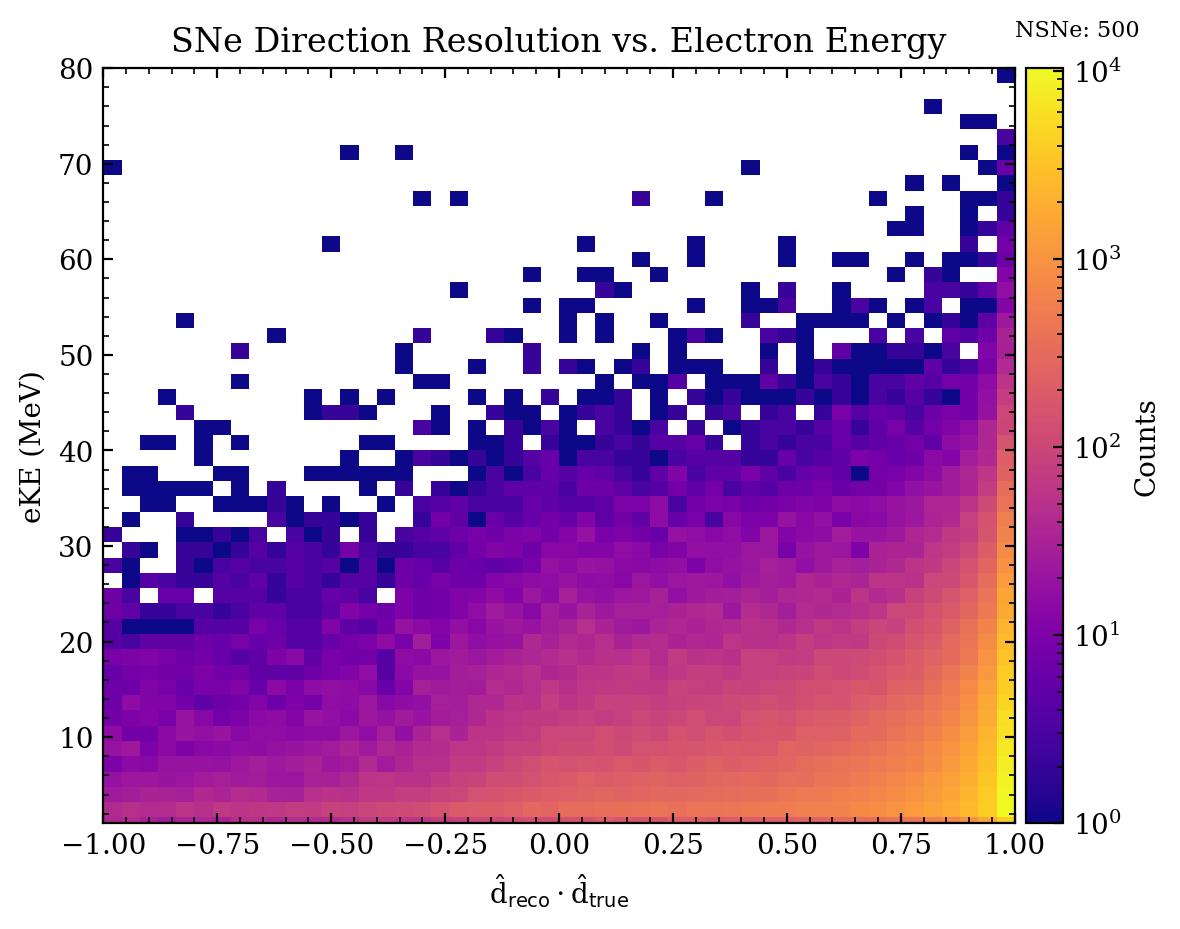

In [4]:
# drop the -999 values (failed fits)
cos = df_comb['cosalpha'][:]
eKE = df_comb['eKE'][:]
mask = np.logical_and(cos != -999, eKE != 0.0)
cos = cos[mask]
eKE = eKE[mask]

plt.figure(figsize=(7, 5), dpi=200)
plt.hist2d(cos, eKE, bins=50, range=[[-1,1], [0, 80]], norm=matplotlib.colors.LogNorm(), cmap='plasma')
# plt.scatter(cos, eKE, s=0.1, alpha=1, color='black', zorder=1000)
plt.ylim(1,)
plt.xlim(-1,1)
plt.colorbar(pad=0.01, label="Counts")
plt.xlabel("$\\hat{d}_{\\rm reco}\cdot \\hat{d}_{\\rm true}$")
plt.ylabel("eKE (MeV)")
plt.title("SNe Direction Resolution vs. Electron Energy")
plt.text(1, 1.05, f"NSNe: {df_comb['sn_direction'].len()/3:.0f}", ha='left', va='center', fontsize=8, zorder=900,
         transform=plt.gca().transAxes)
plt.savefig("images/sne_direction_resolution_vs_electron_energy.jpg", dpi=300, bbox_inches='tight')
plt.show()

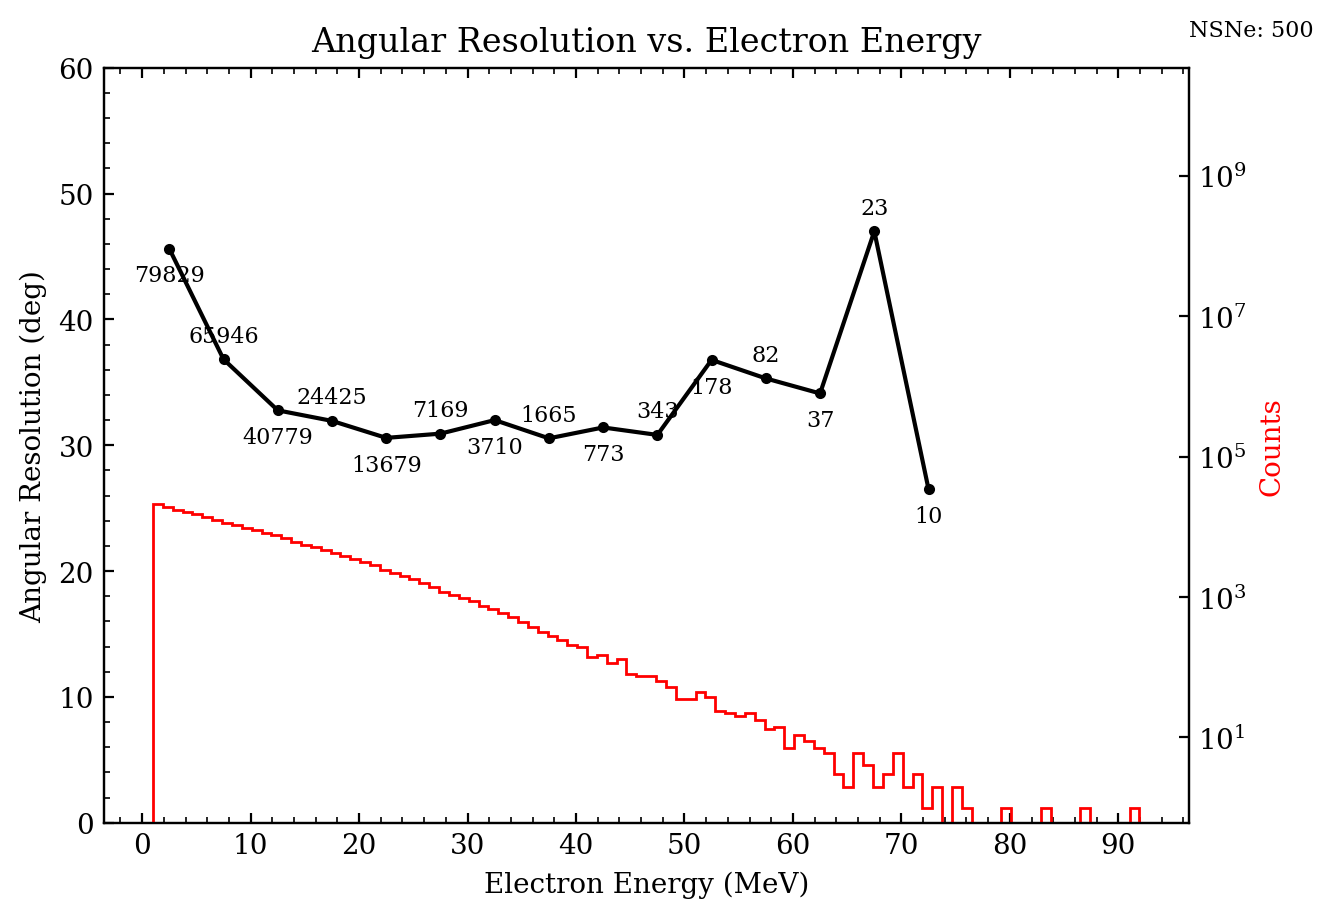

In [5]:
def res_between(cosalpha:np.ndarray, energies:np.ndarray, energy:float, width):
    mask = np.logical_and(energies > energy, energies < energy + width)
    cos = cosalpha[mask]
    deg = np.arccos(cos) * 180 / np.pi
    return np.percentile(deg, 68.3), mask.sum()

eKE_bins = np.arange(0, 80, 5)
diff = np.diff(eKE_bins)[0]
resolutions = []
eKEs = []
ns = []
for curr_eKE in eKE_bins[:-1]:
    try: 
        r, n = res_between(cos, eKE, curr_eKE, diff)
        
        resolutions.append(r)
        eKEs.append(curr_eKE + diff/2)
        ns.append(str(n))
    except IndexError:
        pass
    
plt.figure(figsize=(7, 5), dpi=200)
plt.plot(eKEs, resolutions, color='k', zorder=10, marker='o', markersize=3)
for i, (_eKE, _resolution, _n) in enumerate(zip(eKEs, resolutions, ns)):
    plt.text(_eKE, _resolution+2*(-1)**(i+1) - 1, _n, ha='center', va='bottom', fontsize=8, zorder=900)
plt.xlabel("Electron Energy (MeV)")
plt.ylabel("Angular Resolution (deg)")
plt.ylim(0,60)
plt.twinx()
c = plt.hist(eKE, bins=100, histtype='step', color='red', label='eKE', zorder=-1)
plt.ylabel("Counts", color='red')
plt.yscale("log")
plt.ylim(None, plt.ylim()[1]*1e6)
# plt.xlim(0,)
plt.xticks(np.arange(0,100,10))
plt.title("Angular Resolution vs. Electron Energy")
plt.text(1, 1.05, f"NSNe: {df_comb['sn_direction'].len()/3:.0f}", ha='left', va='center', fontsize=8, zorder=900,
         transform=plt.gca().transAxes)
plt.savefig("images/angular_resolution_vs_eKE.jpg", dpi=300, bbox_inches='tight')
plt.show()

### Calculating the event rate for a single SNe in THEIA

In [24]:
from generator.eEs_generator import generator
from tqdm.notebook import trange

events = []

# theoretical # of events in 100 kT of LABPPO
NUM_EVENTS_100KT_LABPPO = 1052.0
THEIA_KT = 50

# thresholds
eThreshold = 1  # MeV
nuThreshold = 2 # MeV

# sample theoretical # of events, removing any events below
# the thresholds, and find the total #
def get_nevents(__):
    nevents = 0
    total_events = NUM_EVENTS_100KT_LABPPO * THEIA_KT / 100
    for _ in range(int(total_events)):
        event = generator.genEvent(eThreshold=0, nuThreshold=0)
        if event['eKE'] < eThreshold or \
           event['nuEnergy'] < nuThreshold:
            continue
        nevents += 1
    return nevents

# use our many cores to speed up the process
import multiprocessing
N_SAMPLES = 10000*5
ncores = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=ncores) as p:
    r = list(tqdm.tqdm(p.imap(get_nevents, range(N_SAMPLES)), total=N_SAMPLES))

100%|██████████| 50000/50000 [11:06<00:00, 75.06it/s]


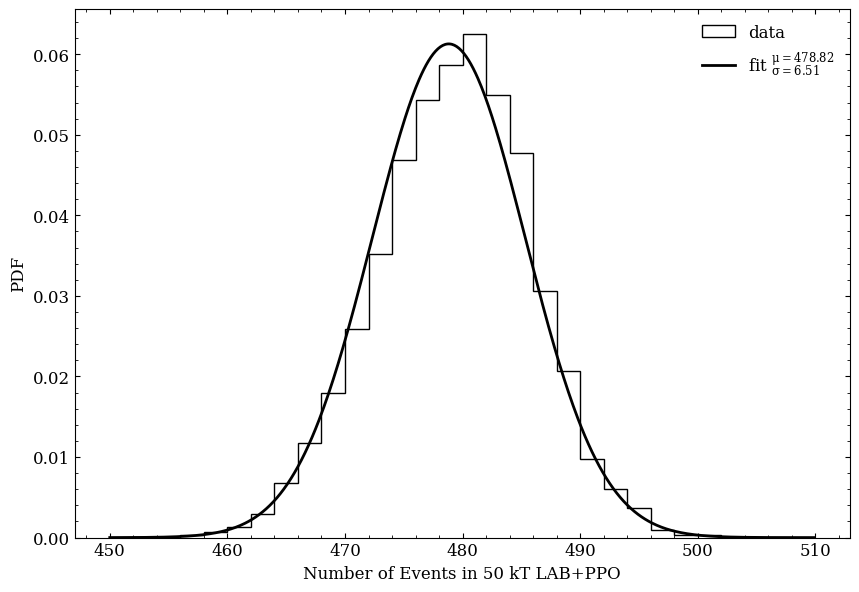

In [27]:
plt.hist(r, bins=np.arange(450, 510, 2), histtype='step', color='k', density=True, label='data')
m, s = scipy.stats.norm.fit(r)
x = np.arange(450, 510, 0.1)
p = scipy.stats.norm.pdf(x, m, s)
plt.plot(x, p, 'k', linewidth=2, label=f'fit $^{{\\mu={m:0.2f}}}_{{\\sigma={s:0.2f}}}$')

plt.xlabel("Number of Events in 50 kT LAB+PPO")
plt.ylabel("PDF")
plt.legend(frameon=False)
plt.show()
